# Testing of qpms.hexpoints
The hexpoints module contains functions to generate 2D triangular lattice
points around the origin, hexagonal lattice complement to the triangular lattice,
and a indices to select important subsets of the generated lattices, 
in order to utilize symmetries to speed up computations of the multipole 
translation operators on the lattices.

In [1]:
import qpms
from qpms import generate_trianglepoints, generate_trianglepoints_hexcomplement
import numpy as np
from numpy import newaxis as nx
import math
import cmath
import os
from scipy.constants import c, e as eV, hbar
s3 = math.sqrt(3)
J_scat = 3

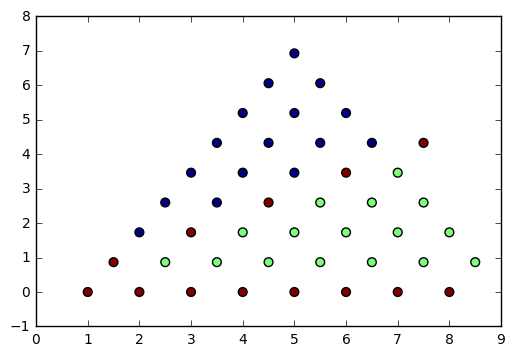

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
maxlayer = 10
ares =  generate_trianglepoints(maxlayer, circular=True, sixthindices = True, mirrorindices=True)
si = ares['si']
mi = ares['mi']
nmi = ares['nmi']
#print(si, mi, nmi)
apoints = ares['points'][mi[1]]
bpoints = ares['points'][mi[0]]
cpoints = ares['points'][nmi]
allpoints = np.concatenate((apoints, bpoints, cpoints), axis=0)
#print(len(apoints))
col=np.concatenate((np.full((len(apoints),),1, dtype=int),np.full((len(bpoints),),2, dtype=int), np.full((len(cpoints),),3, dtype=int)))
plt.scatter(allpoints[:,0], allpoints[:,1], c=col, s=40
           )

In [3]:
%timeit generate_trianglepoints(1000,include_origin=True, sixthindices=True, mirrorindices=True, circular=True)

1 loop, best of 3: 329 ms per loop


In [4]:
%timeit generate_trianglepoints_hexcomplement(1000, thirdindices=True, mirrorindices=True, circular=False)

1 loop, best of 3: 271 ms per loop


In [5]:
#----------------

epsilon_b = 2.3104
hexside = 375e-9
lMax = 3
maxlayer = 33 

omega_eV=3.

my, ny = qpms.get_mn_y(lMax)
nelem = len(my)



omega = omega_eV * eV / hbar

k_0 = omega * math.sqrt(epsilon_b) / c
print(k_0)

#Mie-type T-matrix
ω_p = 9*eV/hbar
ε_inf = 4.6
γ_p = 0.1*eV/hbar
part_radius = 50e-9
epsilon_i = qpms.ε_drude(ε_inf, ω_p, γ_p, omega)
k_i = cmath.sqrt(epsilon_i)*omega/c


trianglepoints=generate_trianglepoints(maxlayer)
trianglepoints_complement=generate_trianglepoints_hexcomplement(maxlayer)

unitcell_translations = hexside*s3*trianglepoints
u2d_translations= hexside*s3*trianglepoints_complement
d2u_translations= -hexside*s3*trianglepoints_complement

a_self = np.empty((unitcell_translations.shape[0],nelem, nelem), dtype=complex)
b_self = np.empty((unitcell_translations.shape[0],nelem, nelem), dtype=complex)
a_u2d = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
b_u2d = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
a_d2u = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)
b_d2u = np.empty((u2d_translations.shape[0],nelem,nelem), dtype=complex)

for j in range(a_self.shape[0]):
    d_i2j = qpms.cart2sph(unitcell_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            #print(my[yj],ny[yj],my[yi],ny[yi],d_i2j[0]*k_0,d_i2j[1],d_i2j[2],False,J_scat)
            a_self[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_self[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
for j in range(a_u2d.shape[0]):
    d_i2j = qpms.cart2sph(u2d_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            a_u2d[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_u2d[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
for j in range(a_d2u.shape[0]):
    d_i2j = qpms.cart2sph(d2u_translations[j])
    for yi in range(nelem):
        for yj in range(nelem):
            a_d2u[j, yj, yi] = qpms.Ã(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)
            b_d2u[j, yj, yi] = qpms.B̃(my[yj],ny[yj],my[yi],ny[yi],kdlj=d_i2j[0]*k_0,θlj=d_i2j[1],φlj=d_i2j[2],r_ge_d=False,J=J_scat)

output_prefix = './diracpoints-data/testing/%d/' % maxlayer

os.makedirs(output_prefix, exist_ok=True)
np.savez(output_prefix+str(omega_eV),
	omega = omega,
	a_self=a_self, b_self=b_self, a_u2d=a_u2d, b_u2d=b_u2d,	a_d2u=a_d2u, b_d2u=b_d2u,
	unitcell_translations=unitcell_translations,u2d_translations=u2d_translations,
	#u2d_translations_0=u2d_translations_0
	)

23108852.258916322


# Test of the translation coefficients obtained by symmetry

In [6]:
tpdict=generate_trianglepoints(maxlayer, sixthindices=True, mirrorindices=True)
tpdict_complement=generate_trianglepoints_hexcomplement(maxlayer, thirdindices=True, mirrorindices=True)
ti = tpdict_complement['ti']
si = tpdict['si']
a_self_new = np.empty(a_self.shape, dtype=complex)
b_self_new = np.empty(b_self.shape, dtype=complex)
a_u2d_new = np.empty(a_u2d.shape, dtype=complex)
b_u2d_new = np.empty(b_u2d.shape, dtype=complex)
a_d2u_new = np.empty(a_u2d.shape, dtype=complex)
b_d2u_new = np.empty(b_u2d.shape, dtype=complex)

## Triangular lattices, 2π/6 rotations only

In [7]:
a_self_new[si[0]] = a_self[si[0]]
b_self_new[si[0]] = b_self[si[0]]
for i in range(1,6):
    a_self_new[si[i],:,:] = a_self_new[si[0],:,:] * np.exp(1j*2*math.pi/6*i*(my[nx,:]-my[:,nx]))
    b_self_new[si[i],:,:] = b_self_new[si[0],:,:] * np.exp(1j*2*math.pi/6*i*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_self_new-a_self)/np.abs(a_self))),
       np.max(np.nan_to_num(np.abs(b_self_new-b_self)/np.abs(b_self))),)
       

3.67140130007e-13 3.61229347096e-13


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


~ 3.6e-13 relative error. Not that bad.
## Triangular lattices, mirror and 2π/6 rotations

In [8]:
mi = tpdict['mi']
nmi = tpdict['nmi']
a_self_new[nmi] = a_self[nmi]
b_self_new[nmi] = b_self[nmi]
a_self_new[mi[0]] = a_self[mi[0]]
b_self_new[mi[0]] = b_self[mi[0]]
mirrorangles = (qpms.cart2sph(unitcell_translations[mi[1]]) - qpms.cart2sph(unitcell_translations[mi[0]]))[:,2]
a_self_new[mi[1],:,:] = a_self_new[mi[0],:,:] * np.exp(1j*mirrorangles[:,nx,nx]*(my[nx,nx,:]-my[nx,:,nx]))
b_self_new[mi[1],:,:] = b_self_new[mi[0],:,:] * np.exp(1j*mirrorangles[:,nx,nx]*(my[nx,nx,:]-my[nx,:,nx]))
for i in range(1,6):
    a_self_new[si[i],:,:] = a_self_new[si[0],:,:] * np.exp(1j*2*math.pi/6*i*(my[nx,:]-my[:,nx]))
    b_self_new[si[i],:,:] = b_self_new[si[0],:,:] * np.exp(1j*2*math.pi/6*i*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_self_new-a_self)/np.abs(a_self))),
       np.max(np.nan_to_num(np.abs(b_self_new-b_self)/np.abs(b_self))),)

3.4467352179e-13 3.51558542283e-13


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


~ 3.5e-13 relative error. Again quite nice.
## Hexagonal lattice complement, 2π/3 rotations

In [9]:
a_u2d_new[ti[0]] = a_u2d[ti[0]]
b_u2d_new[ti[0]] = b_u2d[ti[0]]
for i in range(1,3):
    a_u2d_new[ti[i],:,:] = a_u2d_new[ti[0],:,:] * np.exp(1j*2*math.pi/3*i*(my[nx,:]-my[:,nx]))
    b_u2d_new[ti[i],:,:] = b_u2d_new[ti[0],:,:] * np.exp(1j*2*math.pi/3*i*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_u2d_new-a_u2d)/np.abs(a_u2d))),
       np.max(np.nan_to_num(np.abs(b_u2d_new-b_u2d)/np.abs(b_u2d))),)

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


2.97389351153e-13 3.02264819503e-13


~3e-13 relative error. Still OK!
## Hexagonal lattice complement, mirror and 2π/3 rotations

In [10]:
mi = tpdict_complement['mi']
nmi = tpdict_complement['nmi']
a_u2d_new[nmi] = a_u2d[nmi]
b_u2d_new[nmi] = b_u2d[nmi]
a_u2d_new[mi[0]] = a_u2d[mi[0]]
b_u2d_new[mi[0]] = b_u2d[mi[0]]
mirrorangles = (qpms.cart2sph(u2d_translations[mi[1]]) - qpms.cart2sph(u2d_translations[mi[0]]))[:,2]
a_u2d_new[mi[1],:,:] = a_u2d_new[mi[0],:,:] * np.exp(1j*mirrorangles[:,nx,nx]*(my[nx,nx,:]-my[nx,:,nx]))
b_u2d_new[mi[1],:,:] = b_u2d_new[mi[0],:,:] * np.exp(1j*mirrorangles[:,nx,nx]*(my[nx,nx,:]-my[nx,:,nx]))
for i in range(1,3):
    a_u2d_new[ti[i],:,:] = a_u2d_new[ti[0],:,:] * np.exp(1j*2*math.pi/3*i*(my[nx,:]-my[:,nx]))
    b_u2d_new[ti[i],:,:] = b_u2d_new[ti[0],:,:] * np.exp(1j*2*math.pi/3*i*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_u2d_new-a_u2d)/np.abs(a_u2d))),
       np.max(np.nan_to_num(np.abs(b_u2d_new-b_u2d)/np.abs(b_u2d))),)

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


2.97389351153e-13 3.02372252736e-13


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide


~3e-13 relative error. Still OK!
## Hexagonal lattice complement, opposite direction by π rotation

In [11]:
a_d2u_new[:,:,:] = a_u2d_new[:,:,:] * np.exp(1j*math.pi*(my[nx,:]-my[:,nx]))
b_d2u_new[:,:,:] = b_u2d_new[:,:,:] * np.exp(1j*math.pi*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_d2u_new-a_d2u)/np.abs(a_d2u))),
       np.max(np.nan_to_num(np.abs(b_d2u_new-b_d2u)/np.abs(b_d2u))),)

/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


2.97389351153e-13 3.0231172602e-13


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [12]:
#alternative way (from the original source)
a_d2u_new[:,:,:] = a_u2d[:,:,:] * np.exp(1j*math.pi*(my[nx,:]-my[:,nx]))
b_d2u_new[:,:,:] = b_u2d[:,:,:] * np.exp(1j*math.pi*(my[nx,:]-my[:,nx]))
print( np.max(np.nan_to_num(np.abs(a_d2u_new-a_d2u)/np.abs(a_d2u))),
       np.max(np.nan_to_num(np.abs(b_d2u_new-b_d2u)/np.abs(b_d2u))),)

3.88736960405e-15 3.68907678183e-15


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


In [13]:
#one more way (avoid complex exp)
a_d2u_new[:,:,:] = a_u2d[:,:,:] * (-1)**(my[nx,:]-my[:,nx])
b_d2u_new[:,:,:] = b_u2d[:,:,:] * (-1)**(my[nx,:]-my[:,nx])
print( np.max(np.nan_to_num(np.abs(a_d2u_new-a_d2u)/np.abs(a_d2u))),
       np.max(np.nan_to_num(np.abs(b_d2u_new-b_d2u)/np.abs(b_d2u))),)

3.13962640051e-15 3.08816910101e-15


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


# Can we achieve better asymptotic complexity by calculating translation coeffs for each distance only once?

In other words, with fixed centre in some (triangular) lattice point, is the density of circles intersecting 
other lattice points (more precisely, density of their radii R) proportional to R^2 or is it something better?

The answer (as can be seen from numerics below) seems to be negative. So, in theory, we could 
speed things up by some constant factor, but we can not improve the time complexity this way.

Btw, the relevant thing has the '_cor' suffix. Ignore the stuff without it.

In [14]:
maxvertcount = 8000
maxhorcount = int(maxvertcount*2/s3)

#ignore this:
r2s = set()
for i in range(maxvertcount):
    for j in range(maxhorcount):
        r2 = i**2 + 3*j**2
        if (r2 > maxvertcount**2):
            break
        r2 //= 4
        r2s.add(r2)


In [15]:
# this is the correct way (evens with evens, odds with odds)
r2s_cor = set()
for i in range(maxvertcount//2):
    for j in range(maxhorcount//2):
        r2 = (2*i)**2 + (2*3*j)**2
        if (r2 > maxvertcount**2):
            break
        r2 //= 4
        r2s_cor.add(r2)
        r2 = (2*i+1)**2 + (3*(2*j+1))**2
        if (r2 > maxvertcount**2):
            break
        r2 //= 4
        r2s_cor.add(r2)

        

In [16]:
r2sa = np.array(sorted(r2s))
r2sa_cor = np.array(sorted(r2s_cor))

In [17]:
hits = np.zeros((max(r2s)+1,), dtype=bool)
hits[r2sa] = True
cumhits = np.cumsum(hits)
hits_cor = np.zeros((max(r2s)+1,), dtype=bool)
hits_cor[r2sa_cor] = True
cumhits_cor = np.cumsum(hits_cor)

(0.40392400011489205, 0.20830417448098909)

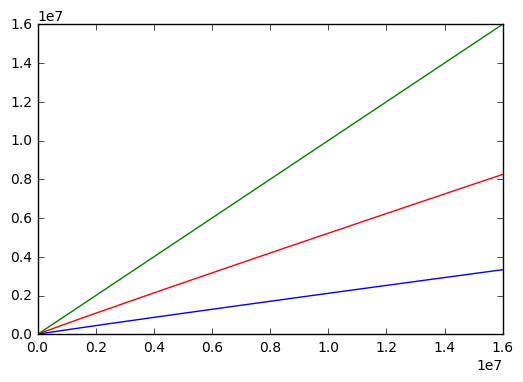

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(np.arange(len(cumhits)), cumhits, 'r',
        np.arange(len(cumhits)), np.arange(len(cumhits)), 'g',
        np.arange(len(cumhits)), cumhits_cor, 'b')
cumhits_cor[-1] / cumhits[-1], cumhits_cor[-1]/len(cumhits)